# Strava Data

In [32]:
from strava_api import GetStravaData
import ipydatagrid as dg
import pandas as pd
import plotly.express as px
import datetime as dt

### Strava Client Credentials 

To retrieve your activities from Strava API you need a Client ID, Client Secret and Athelete ID. 

This can be set up and retrieved from your strava account api -  https://www.strava.com/settings/api 


In [2]:
my_client_id = input("Enter Your Strava client id: ")

my_client_secret = input("Enter Your Strava Client Secret: ")

my_athlete_id = input("Enter Your Strava Athlete id: ")

my_max_heart_rate = input ("Enter Max Heart rate: ") 

Enter Your Strava client id:  120454
Enter Your Strava Client Secret:  b4f546f977f0e8867001cf786db4697a0936a9f8
Enter Your Strava Athlete id:  12982247
Enter Max Heart rate:  190


In [3]:
strava_api = GetStravaData(client_id=my_client_id, client_secret=my_client_secret, athlete_id=my_athlete_id)
strava_metrics = strava_api.fetch_activities_df()

Grant authorise access:
https://www.strava.com/oauth/authorize?client_id=120454&redirect_uri=http%3A%2F%2Flocalhost%3A8081&response_type=code&scope=activity%3Aread_all


Enter the post authorisation code:  91aaaca6d3f2f54608ab3c2b47a786e885c641bd


### Strava Dataframe

Dataframe containing all exercise activities from Strava 

In [5]:
strava_data = dg.DataGrid(strava_metrics)
display(strava_data)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

## Transform Strava Data 

- We use max and average heart rate data to catagorise running activities into 'running zones'
- For more information on running zones see - https://www.forbes.com/health/fitness/running-heart-rate-zones/ 

In [20]:
strava_metrics['heart_rate_percentage'] = strava_metrics['average_heartrate'] / max_heart_rate * 100 

def calculate_running_heart_rate_zone(row):
    percentage = row['heart_rate_percentage']

    if percentage >= 60 and percentage < 70:
        return "Zone 2"
    elif percentage >= 70 and percentage < 80:
        return "Zone 3"
    elif percentage >= 80 and percentage < 90:
        return "Zone 4"
    elif percentage >= 90:
        return "Zone 5"
    else:
        return "Zone 1"

strava_metrics['zone_string'] = strava_metrics.apply(calculate_running_heart_rate_zone, axis=1)

strava_metrics['start_date'] = pd.to_datetime(strava_metrics['start_date'])

# filter out null average heart data - no heart rate data  be featured without smart watch 
running_data = strava_metrics[(strava_metrics['average_heartrate'].notnull()) & (strava_metrics['type']=='Run') ].reset_index(drop=True)

# Group by week and and count number of runs by running zone 
running_zone = running_data.groupby([pd.Grouper(key="start_date", freq="W"), 'zone_string']).count().reset_index()

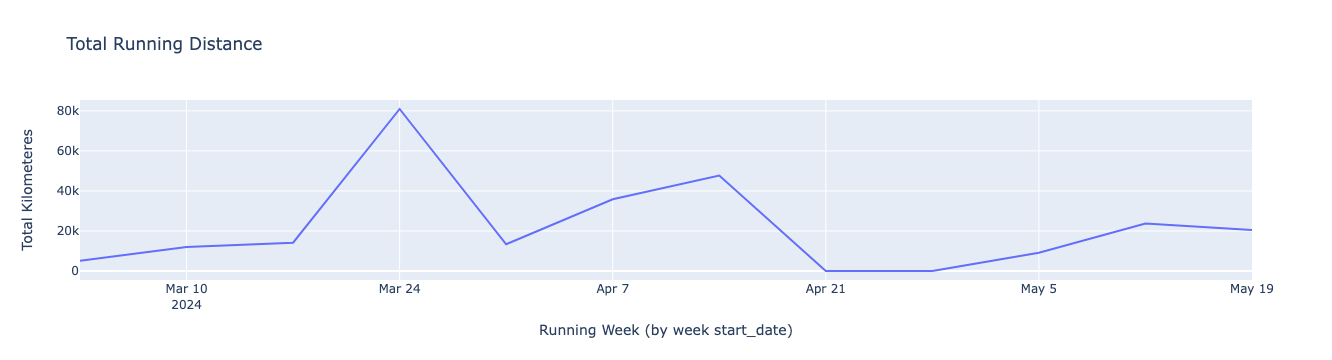

In [52]:
total_kms_week = running_data.groupby(pd.Grouper(key="start_date", freq="W"))['distance'].sum().reset_index()

fig = px.line(total_kms_week, x="start_date", y="distance", title='Total Running Distance')
fig.update_layout(xaxis_title ="Running Week (by week start_date)", yaxis_title = "Total Kilometeres")
fig.show()

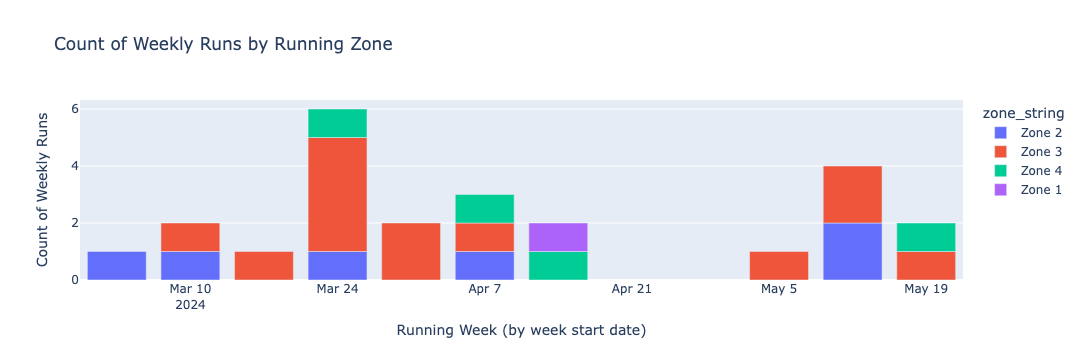

In [50]:
fig = px.bar(running_zone, x = "start_date", y = "suffer_score",color = "zone_string", title = "Count of Weekly Runs by Running Zone")
fig.update_layout(xaxis_title ="Running Week (by week start date)", yaxis_title = "Count of Weekly Runs")
fig.show()

## Running Cadence Analysis

Running Cadence measures steps per a minute. The optimal running cadence is between 170 - 180spm according to scientific studies. 

Studies have found low cadence can result in being more injury prone;  we analyse distribution of running cadence and average running cadence over time  

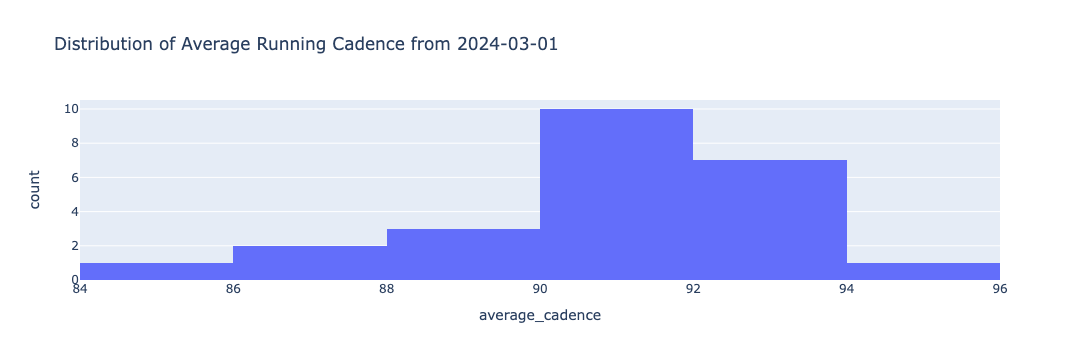

In [47]:
# distribution of average running cadence graph 
earliest_running_date = running_data["start_date"].dt.date.min()
fig = px.histogram(running_data, x="average_cadence", title = f"Distribution of Average Running Cadence from {earliest_running_date}" )
fig.show() 

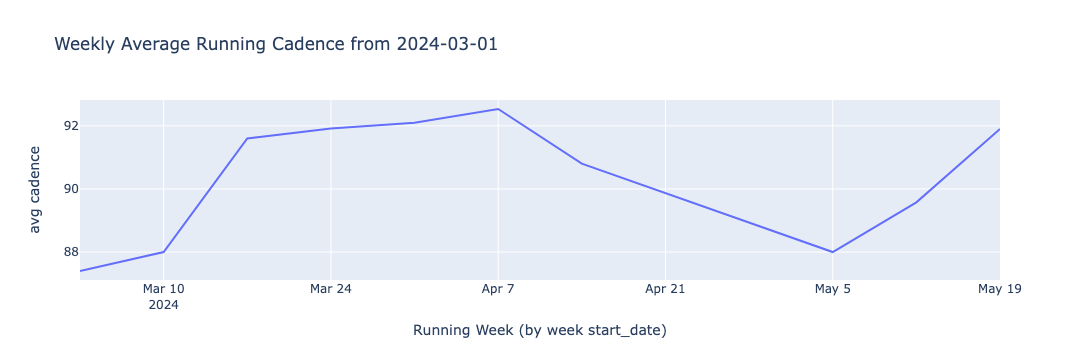

In [68]:
group_cadence_by_week = running_data.groupby(pd.Grouper(key="start_date", freq="W"))['average_cadence'].mean().reset_index()
avg_cadence_time = group_cadence_by_week[(group_cadence_by_week['average_cadence'].notnull())]
fig = px.line(avg_cadence_time, x="start_date", y="average_cadence", title = f"Weekly Average Running Cadence from {earliest_running_date}")
fig.update_layout(xaxis_title ="Running Week (by week start_date)", yaxis_title = "avg cadence")
fig.show()